# ----- START -----

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from tqdm.notebook import tqdm
from pprint import pprint
import cv2
import sys, os
import glob
import gc
from IPython.display import display
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab_Notebooks/1-DataScience/myPython/0-util')

from my_util import reduce_mem_usage
from my_util import typeInfo
from my_util import showImage

a = np.array([[0, 1, 2], 
            [3, 4, 5]])
typeInfo('a', a)

Mounted at /content/drive
a : <ndarray> , (2, 3) , int64 , 0 ~ 5


In [ ]:
# !apt-get install tree

#//$// apt install する場合
w = !apt-get install tree
print(w[-2])

In [ ]:
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize-matplotlib | tail -n 1
    import japanize_matplotlib

In [ ]:
# !pip install python-box

# #//$// pip install する場合
# !pip install python-box | tail -n 1
# from box import Box

try:
    from box import Box
except ImportError:
    !pip install python-box | tail -n 1
    from box import Box

# =============================================== #

# 教師なし学習

## 次元圧縮

### PCA, SVD  (線形)
- Principal Component Analysis
- 主に`処理の高速化`と`データの可視化`のために用いられる
- 変換して低次元にするため，全ての特徴量が必要 → Lassoの様な特徴量選択としての用途は限定的
- 過学習を避けること(=精度の向上)が目的であれば，Lassoなどの特徴量を選択するアルゴリズムの方が一概によい
- 次元が削減されても解釈性は向上しない
- PCAをしても必要な特徴量は減らない(データ取得のコストは下がらない)
- `射影後の分散が最も大きくなる軸`
- PCAは`分散共分散行列の固有ベクトル`を求めればよい
- 次元削除としては，特異点分解(singular value decomposition : SVD)はほぼPCAと同じ意味となる

#### ● Kaggle本

In [ ]:
# PCA
from sklearn.decomposition import PCA

# データは標準化などのスケールを揃える前処理が行われているものとする

# 学習データに基づいてPCAによる変換を定義
pca = PCA(n_components=5)
pca.fit(train_x)

# 変換の適用
train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

In [ ]:
# TruncatedSVD
from sklearn.decomposition import TruncatedSVD

# データは標準化などのスケールを揃える前処理が行われているものとする

# 学習データに基づいてSVDによる変換を定義
svd = TruncatedSVD(n_components=5, random_state=71)
svd.fit(train_x)

# 変換の適用
train_x = svd.transform(train_x)
test_x = svd.transform(test_x)

#### ●かめさん

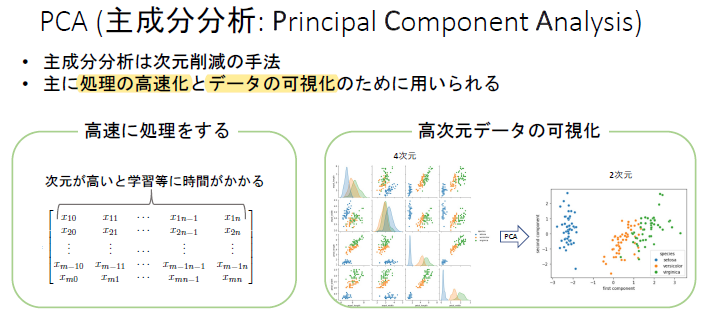

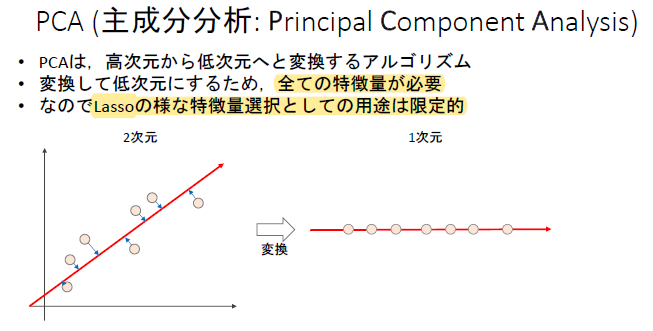

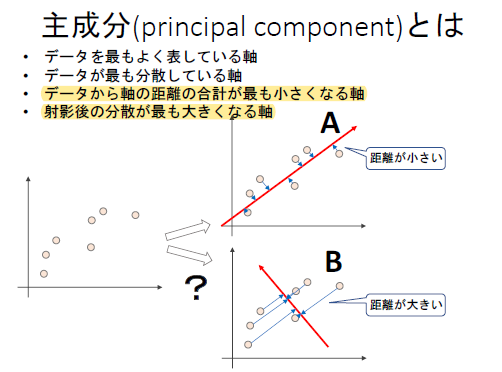

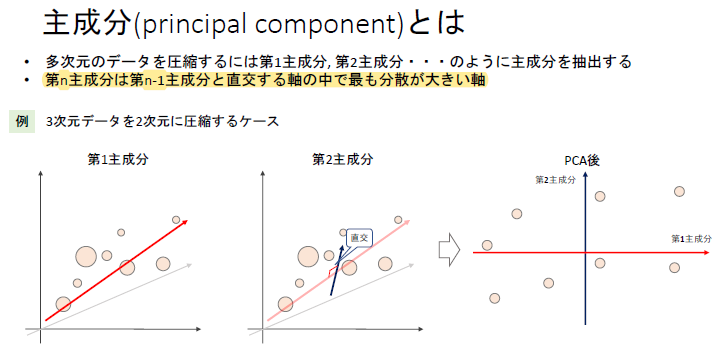

##### PCAのスクラッチ

In [ ]:
# サンプルデータ準備
x = np.array([3, 4, 2, 3, 4, 4, 3])
y = np.array([2, 3, 5, 5, 3, 2, 3])
X = pd.DataFrame({'x': x, 'y': y})
X

,x,y
0,3,2
1,4,3
2,2,5
3,3,5
4,4,3
5,4,2
6,3,3


In [ ]:
# PCAのスクラッチ

def my_pca(X, num_components):
    # step1. 標準化
    X_meaned = X - np.mean(X, axis=0)
    X_scaled = X_meaned / np.std(X_meaned, axis=0)
    
    # step2. 分散共分散行列
    cov_mat = np.cov(X_scaled, rowvar=False)
    
    # step3. 固有ベクトルと固有値
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_evalues = eigen_values[sorted_index]
    sorted_evectors = eigen_vectors[:, sorted_index]
    subset_evectors = sorted_evectors[:, :num_components]
    
    # step4. 変換
    X_reduced = np.dot(X_scaled, subset_evectors)
    
    return X_reduced


my_pca(X, 1)

array([[-0.49467432],
       [-0.89576549],
       [ 2.34350404],
       [ 1.33314107],
       [-0.89576549],
       [-1.50503729],
       [ 0.11459748]])

##### sklearn.decomposition.PCA

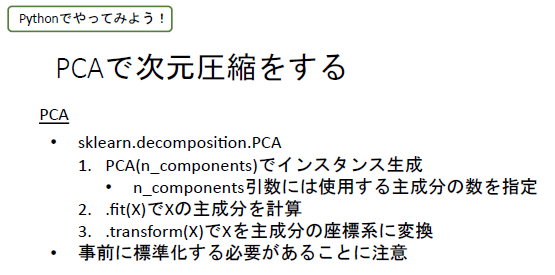

In [ ]:
# sklearnのPCAと比較
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = PCA(n_components=1)
X = scaler.fit_transform(X)
pca.fit_transform(X)

# スクラッチの結果と一致

array([[-0.49467432],
       [-0.89576549],
       [ 2.34350404],
       [ 1.33314107],
       [-0.89576549],
       [-1.50503729],
       [ 0.11459748]])

##### irisデータをPCAで描画

In [ ]:
df = sns.load_dataset('iris')
y_col = 'species'
X = df.loc[:, df.columns!=y_col]
y = df[y_col].values
# 標準化
X_scaled = StandardScaler().fit_transform(X)
# PCA
X_pc = PCA(n_components=2).fit_transform(X_scaled)

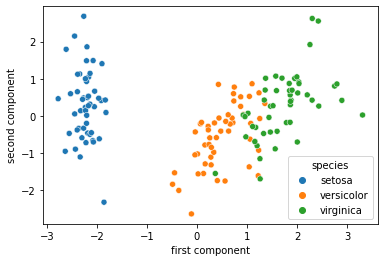

In [ ]:
y = y.reshape(-1, 1)
df_pc = pd.DataFrame(np.concatenate([X_pc, y], axis=1), columns=['first component', 'second component', 'species'])
sns.scatterplot(x='first component', y='second component', hue='species', data=df_pc)

##### 累積寄与率

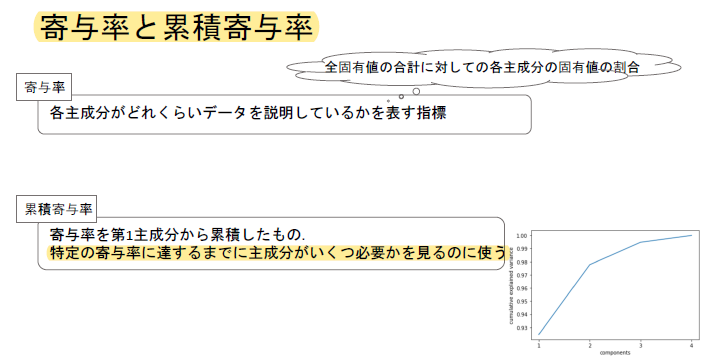

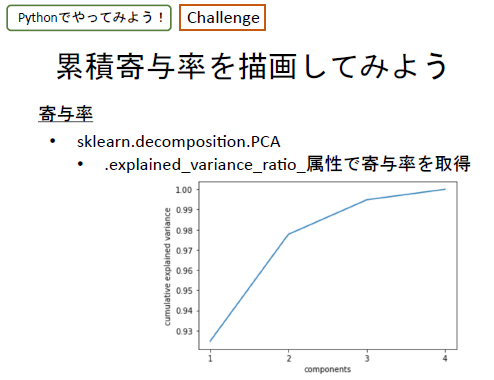

In [ ]:
n_components=4
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=4)

In [ ]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

In [ ]:
# 各主成分(元の特徴量空間の座標系)
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

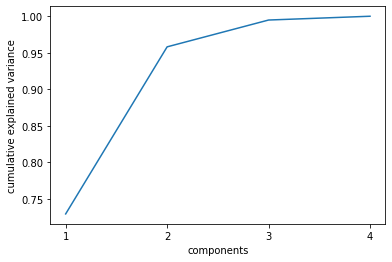

In [ ]:
plt.plot(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, n_components+1))
plt.xlabel('components')
plt.ylabel('cumulative explained variance')
plt.show()

##### MNISTの分類 with PCA

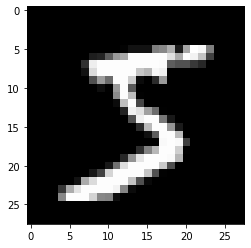

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

# 画像再構成
im = mnist.data.iloc[0].values.reshape(28, 28)
plt.imshow(im, 'gray')

In [ ]:
# hold-out
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.3, random_state=0)
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) #//$//
pca.fit(X_train)

X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [ ]:
print(f"{X_train.shape[-1]} dimensions is reduced to {X_train_pc.shape[-1]} dimensions by PCA")

784 dimensions is reduced to 323 dimensions by PCA


In [ ]:
# ロジスティック回帰(PCAあり)
from sklearn.linear_model import LogisticRegression
import time
model_pca = LogisticRegression()
before = time.time()
model_pca.fit(X_train_pc, y_train)
after = time.time()
print(f"fit took {after-before:.2f}s")

fit took 22.86s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred_pc = model_pca.predict(X_test_pc)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_pc)

0.9195238095238095

In [ ]:
# ロジスティック回帰 (PCAなし)
model = LogisticRegression()
before = time.time()
model.fit(X_train, y_train)
after = time.time()
print(f"fit took {after-before:.2f}s")

# PCAありの方が処理時間が短い

fit took 55.45s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.910047619047619

#### ● Python機械学習プログラミング
https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch05/ch05.ipynb

##### 寄与率(分散説明率)と累積寄与率

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
print(f'{df_wine.shape[0]:,} x {df_wine.shape[1]:,}')
display(df_wine.head(3))

X = df_wine.iloc[:, 1:].values
typeInfo('X', X)
    
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)
typeInfo('X_std', X_std)

178 x 14


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


X : <ndarray> , (178, 13) , float64 , 0.13 ~ 1680.0
X_std : <ndarray> , (178, 13) , float64 , -3.6791622340370105 ~ 4.371372139554768


In [ ]:
# PCA
# n_components=None とすると，主成分が全て保持されるようになり，
# explained_variance_ratio_ 属性を使って分散説明率にアクセスできるようになる

from sklearn.decomposition import PCA
pca = PCA(n_components=None) #//$//
X_pca = pca.fit_transform(X_std)
typeInfo('X_pca', X_pca)
# 特徴量数は変わっていない

X_pca : <ndarray> , (178, 13) , float64 , -4.5850640071482 ~ 5.345388179195737


In [ ]:
# 寄与率 (分散説明率)
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

In [ ]:
# 寄与率を合計したら当然1
np.sum(pca.explained_variance_ratio_)

1.0

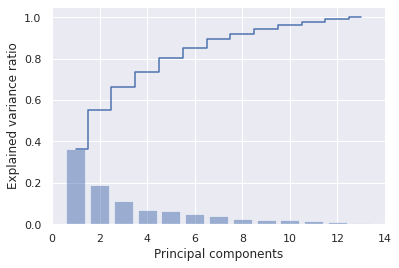

In [ ]:
# 累積寄与率
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

##### PCAで2次元に圧縮後，ロジスティック回帰で学習して決定境界を描画

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
print(f'{df_wine.shape[0]:,} x {df_wine.shape[1]:,}')
display(df_wine.head(3))

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
typeInfo('X', X)
typeInfo('y', y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
typeInfo('X_train', X_train)
typeInfo('X_test', X_test)
typeInfo('y_train', y_train)
typeInfo('y_test', y_test)
    
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
typeInfo('X_train_std', X_train_std)
typeInfo('X_test_std', X_test_std)

178 x 14


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


X : <ndarray> , (178, 13) , float64 , 0.13 ~ 1680.0
y : <ndarray> , (178,) , int64 , 1 ~ 3 , [1 1 1 1 1 1 1 1 1 1]
X_train : <ndarray> , (124, 13) , float64 , 0.13 ~ 1680.0
X_test : <ndarray> , (54, 13) , float64 , 0.17 ~ 1480.0
y_train : <ndarray> , (124,) , int64 , 1 ~ 3 , [3 1 1 1 3 2 2 3 2 2]
y_test : <ndarray> , (54,) , int64 , 1 ~ 3 , [1 2 1 1 2 3 2 3 1 3]
X_train_std : <ndarray> , (124, 13) , float64 , -2.55493448916567 ~ 3.6932366525105946
X_test_std : <ndarray> , (54, 13) , float64 , -3.823226471542036 ~ 4.4758333270522215


In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
typeInfo('X_train_pca', X_train_pca)
typeInfo('X_test_pca', X_test_pca)

# 特徴量が2次元に圧縮されている

X_train_pca : <ndarray> , (124, 2) , float64 , -4.206425966320473 ~ 4.353083972897037
X_test_pca : <ndarray> , (54, 2) , float64 , -3.6995163148861705 ~ 3.6029135228019458


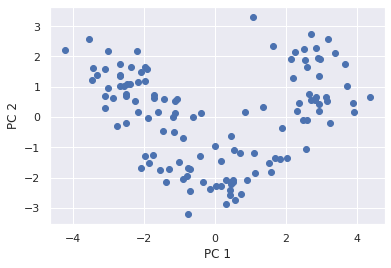

In [ ]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [ ]:
# PCAで2次元に圧縮後の特徴量を，ロジスティック回帰で学習
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

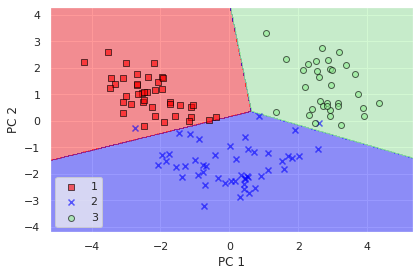

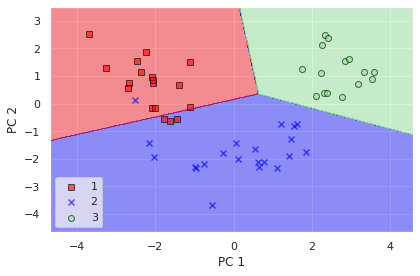

In [ ]:
# 散布図と決定境界を描画

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
        
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

#### ● O'Reilly Pythonではじめる機械学習
https://github.com/kita0623/introduction_to_ml_with_python/blob/master/03-unsupervised-learning.ipynb

##### 圧縮後主成分に含まれる特徴量ヒートマップ

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)
typeInfo('X_scaled', X_scaled)

X_scaled : <ndarray> , (569, 30) , float64 , -3.1120847879199744 ~ 12.072680399588076


In [ ]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=2)
# fit PCA model to beast cancer data
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


In [ ]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


In [ ]:
print("PCA components:\n{}".format(pca.components_))

PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Text(0, 0.5, 'Principal components')

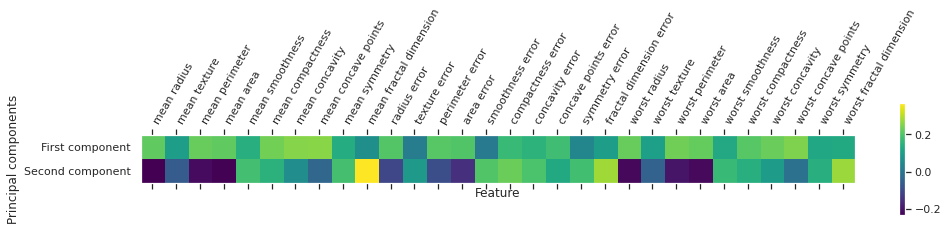

In [ ]:
plt.matshow(pca.components_, cmap='viridis')
plt.grid(False)
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

# 第1主成分を見ると，全ての特徴量が同じ符号になっていることが分かる．これは全ての特徴量に一般的な相関があることを意味する
# 第1主成分, 第2主成分 ともに30の特徴量全てが混ざっている

### LDA (Linear Discriminant Analysis) 教師あり次元圧縮 (線形)
- 線形判別分析
- `教師ありデータ圧縮`
- PCAが教師なしのアルゴリズムであるのに対し，LDAは教師ありのアルゴリズムである．このため，分類タスクの特徴抽出の手段としては，LDAの方が優れている．
- 学習データをうまく分類できるような低次元の特徴空間を探し，元の特徴量をその空間に射影することで次元を削減する．

#### ● Kaggle本

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# データは標準化などのスケールを揃える前処理が行われているものとする

# 学習データに基づいてLDAによる変換を定義
lda = LDA(n_components=1)
lda.fit(train_x, train_y) #//$// yも使っていることに着目！

# 変換の適用
train_x = lda.transform(train_x)
test_x = lda.transform(test_x)

#### ● Python機械学習プログラミング
https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch05/ch05.ipynb  
LDAで2次元に圧縮後，ロジスティック回帰で学習して決定境界を描画

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
print(f'{df_wine.shape[0]:,} x {df_wine.shape[1]:,}')
display(df_wine.head(3))

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
typeInfo('X', X)
typeInfo('y', y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
typeInfo('X_train', X_train)
typeInfo('X_test', X_test)
typeInfo('y_train', y_train)
typeInfo('y_test', y_test)
    
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
typeInfo('X_train_std', X_train_std)
typeInfo('X_test_std', X_test_std)

178 x 14


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


X : <ndarray> , (178, 13) , float64 , 0.13 ~ 1680.0
y : <ndarray> , (178,) , int64 , 1 ~ 3 , [1 1 1 1 1 1 1 1 1 1]
X_train : <ndarray> , (124, 13) , float64 , 0.13 ~ 1680.0
X_test : <ndarray> , (54, 13) , float64 , 0.17 ~ 1480.0
y_train : <ndarray> , (124,) , int64 , 1 ~ 3 , [3 1 1 1 3 2 2 3 2 2]
y_test : <ndarray> , (54,) , int64 , 1 ~ 3 , [1 2 1 1 2 3 2 3 1 3]
X_train_std : <ndarray> , (124, 13) , float64 , -2.55493448916567 ~ 3.6932366525105946
X_test_std : <ndarray> , (54, 13) , float64 , -3.823226471542036 ~ 4.4758333270522215


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train_std, y_train) #//$// yも使っていることに着目！
X_test_lda = lda.transform(X_test_std)

typeInfo('X_train_lda', X_train_lda)
typeInfo('X_test_lda', X_test_lda)
# 特徴量が2次元に圧縮されている

X_train_lda : <ndarray> , (124, 2) , float64 , -5.295263634440594 ~ 5.497952760090491
X_test_lda : <ndarray> , (54, 2) , float64 , -6.186091309800935 ~ 5.214243194181175


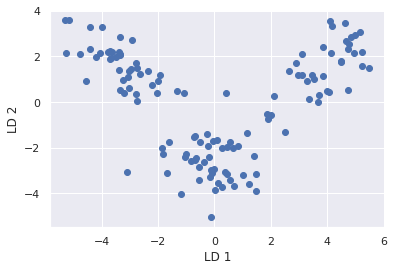

In [ ]:
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1])
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.show()

In [ ]:
# LDAで2次元に圧縮後の特徴量を，ロジスティック回帰で学習
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

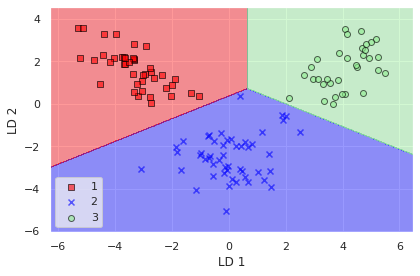

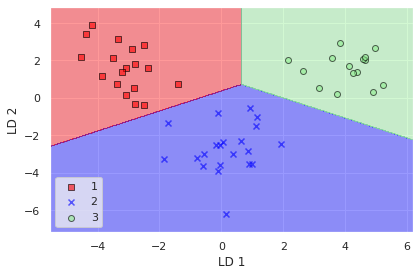

In [ ]:
# 散布図と決定境界を描画

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
        

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_09.png', dpi=300)
plt.show()

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_10.png', dpi=300)
plt.show()

### Kernel PCA (非線形)

#### ● Python機械学習プログラミング
https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch05/ch05.ipynb

### t-SNE (非線形)
- 比較的新しい手法
- 非線形の関係をとらえることができるため，元の特徴量にこれらの圧縮結果を加えて精度が上がることがある．
- 多クラス分類の代表的なコンペであるKaggleの「Otto Group Product Classification Challenge」では，t-SNEで得られた特徴量を加えるだけで大きく精度が向上したため，上位をはじめ多くのソリューションで用いられていました．

#### ● Kaggle本

In [ ]:
import bhtsne

# データは標準化などのスケールを揃える前処理が行われているものとする

# t-sneによる変換
data = pd.concat([train_x, test_x])
embedded = bhtsne.tsne(data.astype(np.float64), dimensions=2, rand_seed=71)

### UMAP
- 2018年に提案された新しい手法
- 実行時間はt-SNEの数分の1程度と言われており，高速であることなどの利点からよく使われている

#### ● Kaggle本

In [ ]:
import umap

# データは標準化などのスケールを揃える前処理が行われているものとする

# 学習データに基づいてUMAPによる変換を定義
um = umap.UMAP()
um.fit(train_x)

# 変換の適用
train_x = um.transform(train_x)
test_x = um.transform(test_x)

# =============================================== #

# ----- END -----